In [91]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns

In [93]:
# Load the dataset
analysis_df = pd.read_csv('analysis.csv')

# Convert the 'Timestamp' to datetime format
analysis_df['Timestamp'] = pd.to_datetime(analysis_df['Timestamp'])
# Determine the split point (e.g., use 80% for training and 20% for testing)
split_point = int(len(analysis_df) * 0.8)

# Extract features from 'Timestamp'
analysis_df['hour'] = analysis_df['Timestamp'].dt.hour
analysis_df['day'] = analysis_df['Timestamp'].dt.day
analysis_df['month'] = analysis_df['Timestamp'].dt.month
analysis_df['year'] = analysis_df['Timestamp'].dt.year
analysis_df['day_of_week'] = analysis_df['Timestamp'].dt.dayofweek
analysis_df['day_of_year'] = analysis_df['Timestamp'].dt.dayofyear

# Split the data based on the split point
train_df = analysis_df[:split_point]
test_df = analysis_df[split_point:]

# Extract the target variable '% Baseline'
y_train = train_df['% Baseline'].values
y_test = test_df['% Baseline'].values

# # Extract features from 'Timestamp'
# train_df['hour'] = train_df['Timestamp'].dt.hour
# train_df['day'] = train_df['Timestamp'].dt.day
# train_df['month'] = train_df['Timestamp'].dt.month
# train_df['year'] = train_df['Timestamp'].dt.year
# train_df['day_of_week'] = train_df['Timestamp'].dt.dayofweek
# train_df['day_of_year'] = train_df['Timestamp'].dt.dayofyear

# test_df['hour'] = test_df['Timestamp'].dt.hour
# test_df['day'] = test_df['Timestamp'].dt.day
# test_df['month'] = test_df['Timestamp'].dt.month
# test_df['year'] = test_df['Timestamp'].dt.year
# test_df['day_of_week'] = test_df['Timestamp'].dt.dayofweek
# test_df['day_of_year'] = test_df['Timestamp'].dt.dayofyear

# Drop the original Timestamp column
X_train = train_df.drop(columns=['Timestamp', '% Baseline'])
X_test = test_df.drop(columns=['Timestamp', '% Baseline'])

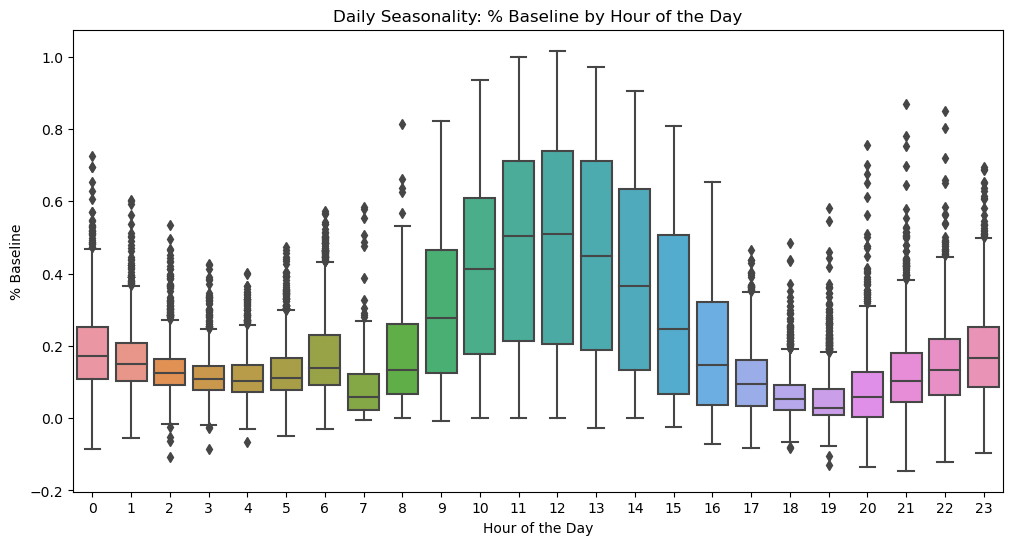

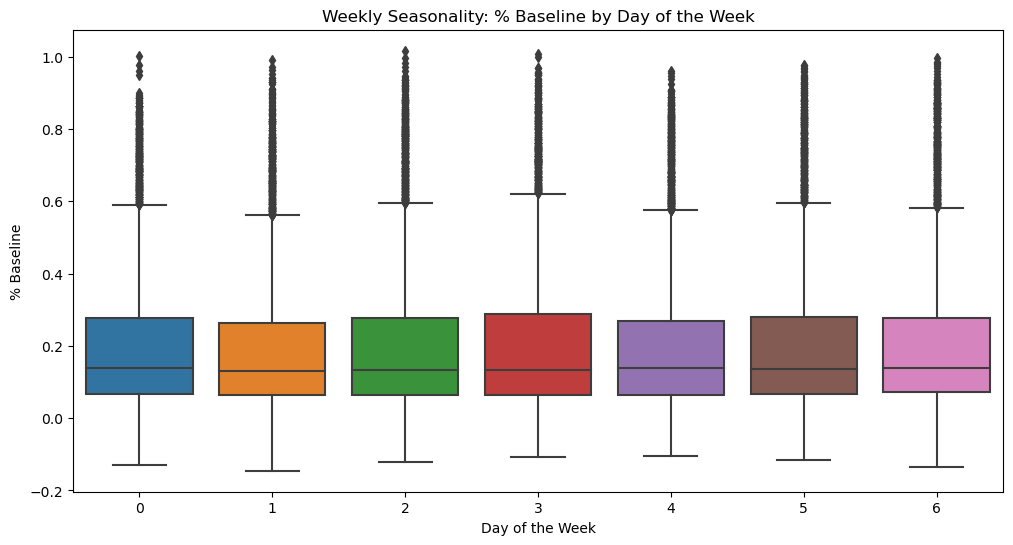

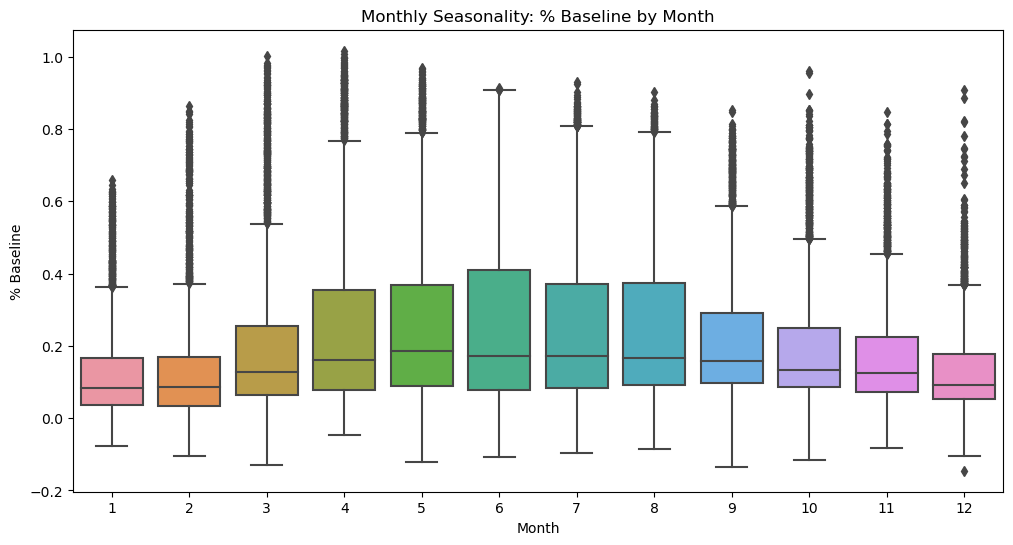

In [94]:
# Daily Seasonality
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='% Baseline', data=analysis_df)
plt.title('Daily Seasonality: % Baseline by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('% Baseline')
plt.show()

# Weekly Seasonality
plt.figure(figsize=(12, 6))
sns.boxplot(x='day_of_week', y='% Baseline', data=analysis_df)
plt.title('Weekly Seasonality: % Baseline by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('% Baseline')
plt.show()

# Monthly Seasonality
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='% Baseline', data=analysis_df)
plt.title('Monthly Seasonality: % Baseline by Month')
plt.xlabel('Month')
plt.ylabel('% Baseline')
plt.show()

In [85]:
# Scale the features (X)
scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

# Define a function to create sequences for LSTM
def create_sequences(data, target, seq_length=10):
    x = []
    y = []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i])
        y.append(target[i])
    return np.array(x), np.array(y)

# Sequence length
seq_length = 10

# Create sequences from training and testing data
X_train_seq, y_train_seq = create_sequences(scaled_X_train, y_train, seq_length)
X_test_seq, y_test_seq = create_sequences(scaled_X_test, y_test, seq_length)

# Reshape X to be 3D [samples, time steps, features]
X_train_seq = X_train_seq.reshape(X_train_seq.shape[0], X_train_seq.shape[1], X_train_seq.shape[2])
X_test_seq = X_test_seq.reshape(X_test_seq.shape[0], X_test_seq.shape[1], X_test_seq.shape[2])

In [86]:
# Build the LSTM model with regularization and ReLU activation
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(units=25, activation='relu'))
model.add(Dense(units=1))  # No activation function here for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with validation data and early stopping
history = model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, validation_data=(X_test_seq, y_test_seq), callbacks=[early_stop])

c:\Users\NAUFAL\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
877/877 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 0.0639 - val_loss: 0.0223
Epoch 2/100
877/877 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0175 - val_loss: 0.0194
Epoch 3/100
877/877 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.0159 - val_loss: 0.0236
Epoch 4/100
877/877 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 0.0148 - val_loss: 0.0184
Epoch 5/100
877/877 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0139 - val_loss: 0.0186
Epoch 6/100
877/877 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 0.0134 - val_loss: 0.0179
Epoch 7/100
877/877 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.0132 - val_loss: 0.0229
Epoch 8/100
877/877 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 0.0129 - val_loss: 0.0169
Epoch 9/100
877/877 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - loss: 0.0125 - val_loss: 0.0233
Epoch 10/100
877/877 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - loss: 0.0124 - val_loss: 0.0201
Epoch 11/100
877/877 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - loss: 0.0125 - val_loss: 0.0174
Epoch 12/100
877/87

877/877 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


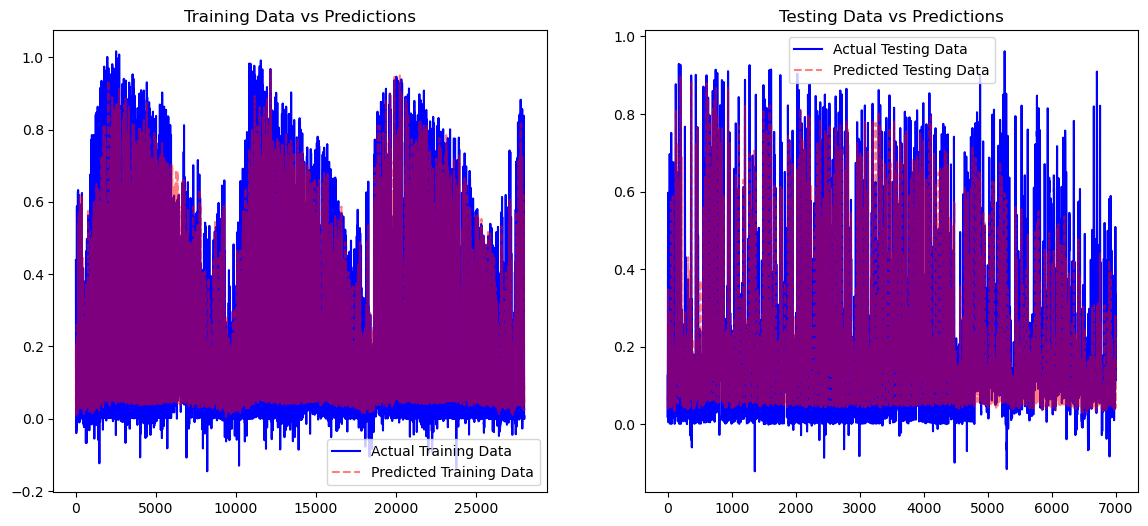

In [87]:
# Predict on training and testing data
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Plot the results
plt.figure(figsize=(14, 6))

# Training data
plt.subplot(1, 2, 1)
plt.plot(y_train_seq, color='blue', label='Actual Training Data')
plt.plot(y_train_pred, color='red', linestyle='--', label='Predicted Training Data',alpha=0.5)
plt.title('Training Data vs Predictions')
plt.legend()

# Testing data
plt.subplot(1, 2, 2)
plt.plot(y_test_seq, color='blue', label='Actual Testing Data')
plt.plot(y_test_pred, color='red', linestyle='--', label='Predicted Testing Data',alpha=0.5)
plt.title('Testing Data vs Predictions')
plt.legend()

plt.show()

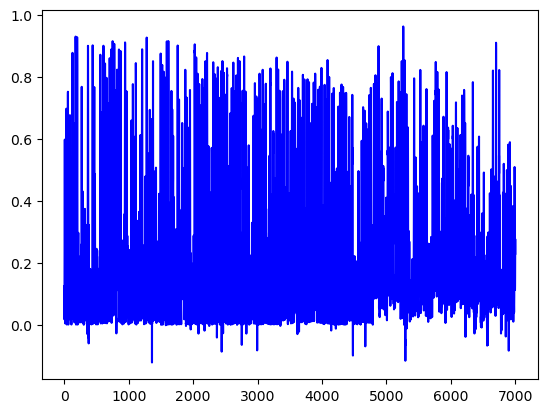

In [88]:
plt.plot(y_test_seq, color='blue', label='Actual Testing Data')
plt.show()

In [76]:
# Load the sample_submission.csv and Weather.csv files
sample_submission_df = pd.read_csv('dataset/sample_submission.csv')
weather_df = pd.read_csv('dataset/Weather.csv')
solar_irradiance_df = pd.read_excel('dataset/Solar_irradiance_full.xlsx')

# Convert the 'Timestamp' column in sample_submission.csv and Weather.csv to datetime format
sample_submission_df['Timestamp'] = pd.to_datetime(sample_submission_df['Timestamp'])
weather_df['date_time'] = pd.to_datetime(weather_df['date_time'])

# Create a 'Timestamp' column in the Solar Irradiance data
solar_irradiance_df['Timestamp'] = pd.to_datetime(solar_irradiance_df[['Year', 'Month', 'Day', 'Hour', 'Minute']])

# Merge the Weather and Solar Irradiance data on the 'Timestamp' column
combined_df = pd.merge(weather_df, solar_irradiance_df, left_on='date_time', right_on='Timestamp', how='inner')

# Filter the combined data based on the timestamps in sample_submission.csv
filtered_combined_df = combined_df[combined_df['Timestamp'].isin(sample_submission_df['Timestamp'])]

# Find the common columns between analysis_df and filtered_combined_df
common_columns = [col for col in analysis_df.columns if col in filtered_combined_df.columns]

# Create a DataFrame with only the common columns
filtered_combined_df_filtered = filtered_combined_df[common_columns]


In [90]:
# Load the sample_submission.csv and Weather.csv files
sample_submission_df = pd.read_csv('dataset/sample_submission.csv')
weather_df = pd.read_csv('dataset/Weather.csv')
solar_irradiance_df = pd.read_excel('dataset/Solar_irradiance_full.xlsx')
# Convert the 'Timestamp' column in sample_submission.csv and Weather.csv to datetime format
sample_submission_df['Timestamp'] = pd.to_datetime(sample_submission_df['Timestamp'])
weather_df['date_time'] = pd.to_datetime(weather_df['date_time'])
# Create a 'Timestamp' column in the Solar Irradiance data
solar_irradiance_df['Timestamp'] = pd.to_datetime(solar_irradiance_df[['Year', 'Month', 'Day', 'Hour', 'Minute']])
# Merge the Weather and Solar Irradiance data on the 'Timestamp' column
combined_df = pd.merge(weather_df, solar_irradiance_df, left_on='date_time', right_on='Timestamp', how='inner')
# Filter the combined data based on the timestamps in sample_submission.csv
filtered_combined_df = combined_df[combined_df['Timestamp'].isin(sample_submission_df['Timestamp'])]
# Find the common columns between analysis_df and filtered_combined_df
common_columns = [col for col in analysis_df.columns if col in filtered_combined_df.columns]
# Create a DataFrame with only the common columns
filtered_combined_df_filtered = filtered_combined_df[common_columns]
submission_df = pd.merge(sample_submission_df, filtered_combined_df_filtered, on='Timestamp', how='inner')
# Extract features from 'Timestamp' in the same way as the training data
submission_df['hour'] = submission_df['Timestamp'].dt.hour
submission_df['day'] = submission_df['Timestamp'].dt.day
submission_df['month'] = submission_df['Timestamp'].dt.month
submission_df['year'] = submission_df['Timestamp'].dt.year
submission_df['day_of_week'] = submission_df['Timestamp'].dt.dayofweek
submission_df['day_of_year'] = submission_df['Timestamp'].dt.dayofyear

# Drop the original Timestamp column
X_submission = submission_df.drop(columns=['Timestamp', '% Baseline'])

# Scale the features (X)
scaled_X_submission = scaler.transform(X_submission)  # Use the same scaler as used for training data

# Create sequences from the scaled submission data
X_submission_seq, _ = create_sequences(scaled_X_submission, np.zeros(len(scaled_X_submission)), seq_length)

# Predict the % Baseline for the sample submission data
predictions = model.predict(X_submission_seq)

# Add the predictions to the sample_submission dataframe
# Ensure that the predictions match the length of the submission_df
predictions = predictions.flatten()  # Flatten to a 1D array if needed
# Create a temporary series to compute the moving average
temp_series = pd.Series(predictions)

# Calculate the moving average using a window of your choice (e.g., 3, 5, etc.)
moving_avg = temp_series.rolling(window=3, min_periods=1).mean()  # 3-point moving average

# Fill the first seq_length NaN values in the submission_df with the moving average
submission_df['% Baseline'].iloc[:seq_length] = moving_avg.iloc[:seq_length]
submission_df['% Baseline'].iloc[seq_length:] = predictions  # Leave first seq_length rows as NaN or fill them

# Save the predictions to a new CSV file
submission_df.to_csv('submit/submission_lstm_v3.csv', index=False)

print("Prediction complete. Results saved to 'submission_lstm_predictions.csv'.")


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Prediction complete. Results saved to 'submission_lstm_predictions.csv'.


C:\Users\NAUFAL\AppData\Local\Temp\ipykernel_28824\4245873769.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission_df['% Baseline'].iloc[:seq_length] = moving_avg.iloc[:seq_length]
C:\Users\NAUFAL\AppData\Local\Temp\ipykernel_28824\4245873769.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission_df['% Baseline'].iloc[seq_length:] = predictions  # Leave first seq_length rows as NaN or fill them
